In [12]:
import numpy as np
import pandas as pd 
import os
import torch
import matplotlib
import matplotlib.pyplot as plt


matplotlib.style.use('ggplot')



In [13]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets


from torch.utils.data import DataLoader


BATCH_SIZE = 16


train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



valid_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



In [14]:


import os
from torch.utils.data import Dataset
from PIL import Image

class FingersDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path)
        
        label_str = img_name.split('_')[-1]
        label = int(label_str[0])          
        
        if self.transform:
            image = self.transform(image)
        return image, label



train_dataset = FingersDataset('/kaggle/input/fingers/train', transform=train_transforms)
valid_dataset = FingersDataset('/kaggle/input/fingers/test', transform=valid_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,      
    num_workers=2,  
    pin_memory=True
)

testloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,      
    num_workers=2,
    pin_memory=True
)


In [15]:
import torch.nn as nn
import torch.nn.functional as F



class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,7)
        self.fc1 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(p = 0.5)
        self.fc2 = nn.Linear(32,12)
        self.MaxPool = nn.MaxPool2d(2,2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.MaxPool(x)
        x = F.relu(self.conv2(x))
        x = self.MaxPool(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
        

In [16]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
   
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm.auto import tqdm


num_epochs = 10

device = ('cuda' if torch.cuda.is_available() else 'cpu')

model = CNNModel().to(device)

optimizer = optim.Adam(model.parameters(), lr = 3e-3)

criterion = nn.CrossEntropyLoss()




In [18]:
def train_model(model, train_дoader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0.0
    counter = 0


    for i ,data in tqdm(enumerate(train_loader), total = len(train_loader)):
        counter += 1
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)


        loss = criterion(outputs,labels)

        train_running_loss += loss.item()

        _, preds = torch.max(outputs.detach(),1)

        train_running_correct += (preds == labels).sum().item()

        loss.backward()

        optimizer.step()


    epoch_loss = train_running_loss / counter

    epoch_acc = train_running_correct / len(train_loader.dataset)


    return epoch_loss , epoch_acc


def validate(model, testloader, criterion):
    model.eval()
    print('Validate')
    validate_running_loss = 0.0
    validate_running_correct = 0.0
    counter = 0
    with torch.no_grad():
        
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            
            counter += 1
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            
            validate_running_loss += loss.item()
    
            _, preds = torch.max(outputs, 1)
            
            validate_running_correct += (preds == labels).sum().item()
    val_loss = validate_running_loss / counter
    val_acc = validate_running_correct / len(testloader.dataset)

    return val_loss, val_acc
    
        

In [19]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []


for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch+1} of {num_epochs}")
    
    train_epoch_loss, train_epoch_acc = train_model(model, train_loader, 
                                              optimizer, criterion)
    
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                 criterion)
    
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    

[INFO]: Epoch 1 of 10
Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validate


  0%|          | 0/225 [00:00<?, ?it/s]

Training loss: 1.001, training acc: 0.556
Validation loss: 0.257, validation acc: 0.958
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validate


  0%|          | 0/225 [00:00<?, ?it/s]

Training loss: 0.432, training acc: 0.808
Validation loss: 0.178, validation acc: 0.949
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validate


  0%|          | 0/225 [00:00<?, ?it/s]

Training loss: 0.349, training acc: 0.841
Validation loss: 0.036, validation acc: 0.997
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validate


  0%|          | 0/225 [00:00<?, ?it/s]

Training loss: 0.301, training acc: 0.869
Validation loss: 0.017, validation acc: 0.998
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validate


  0%|          | 0/225 [00:00<?, ?it/s]

Training loss: 0.299, training acc: 0.871
Validation loss: 0.013, validation acc: 0.996
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validate


  0%|          | 0/225 [00:00<?, ?it/s]

Training loss: 0.271, training acc: 0.885
Validation loss: 0.014, validation acc: 0.997
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validate


  0%|          | 0/225 [00:00<?, ?it/s]

Training loss: 0.272, training acc: 0.882
Validation loss: 0.012, validation acc: 1.000
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validate


  0%|          | 0/225 [00:00<?, ?it/s]

Training loss: 0.256, training acc: 0.896
Validation loss: 0.015, validation acc: 0.998
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validate


  0%|          | 0/225 [00:00<?, ?it/s]

Training loss: 0.218, training acc: 0.913
Validation loss: 0.023, validation acc: 0.997
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validate


  0%|          | 0/225 [00:00<?, ?it/s]

Training loss: 0.199, training acc: 0.926
Validation loss: 0.009, validation acc: 0.999
--------------------------------------------------


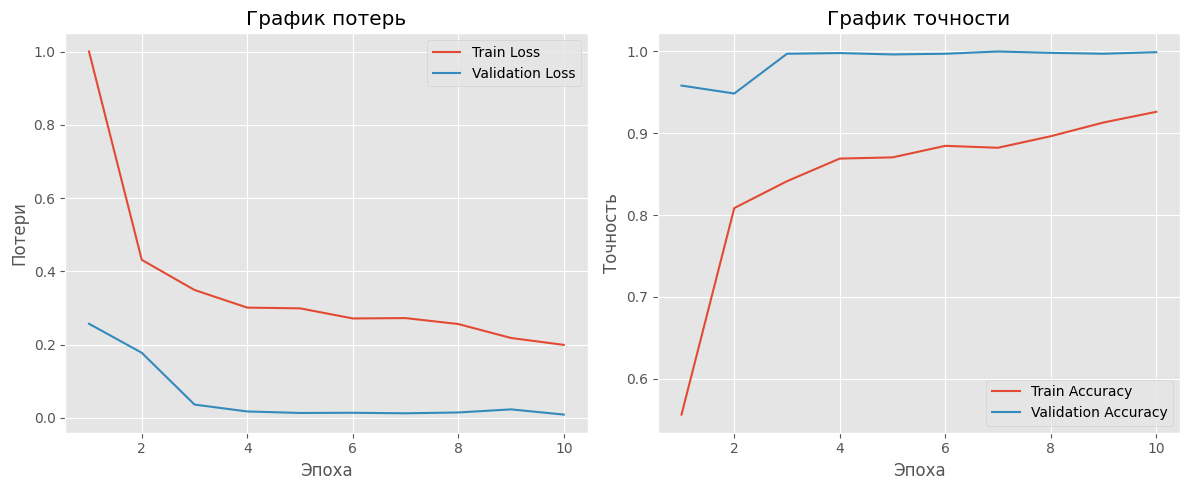

In [20]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, valid_loss, label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('График потерь')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('График точности')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Now i want to use Transform learning and Fine-Tuning to solve this problem

In [30]:
# Загружаем предобученную модель
print(model)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=12, bias=True)
  (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
